In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, grid


In [242]:
indivs_columns = ["CycleIndivs", "FECTransID", "ContribID", "Contrib", "RecipID", "Orgname", "UltOrg", "RealCode", "Date","Amount", "Street", "City", "State", "Zip", "RecipCodeIndivs", "Type", "CmteID", "OtherID", "Gender", "Microfilm","Occupation", "Employer", "Source"]
cands_columns = ['CycleCands','FECCandID','CID','FirstLastP','Party','DistIDRunFor','DistIDCurr','CurrCand','CycleCand','CRPICO','RecipCodeCands','NoPacs']
buffs={}
buffs_cand={}

In [243]:
#now set to one year at a time
years = [10]

#update this to location with individual contribution files
indivs_path = "/Users/admin/Documents/GWU/temp/"


In [244]:
#load individual contributions into buffer
for yr in years:
    df = pd.read_csv(f"{indivs_path}indivs{yr}.txt", quotechar='|', sep=',', header=None, encoding='ISO-8859-1')
    df.columns = indivs_columns
    buffs[yr] = df


/Users/admin/Documents/GitHub/csci6364/estimator/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (13,15,17,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [245]:
#load candidates into buffer
for yr in years:
    df = pd.read_csv(f"../data/candidates/cands{yr}.txt", quotechar='|', sep=',', header=None, encoding='ISO-8859-1')
    df.columns = cands_columns
    buffs_cand[yr] = df


In [246]:
#check years loaded to buffer
buffs.keys()

dict_keys([12])

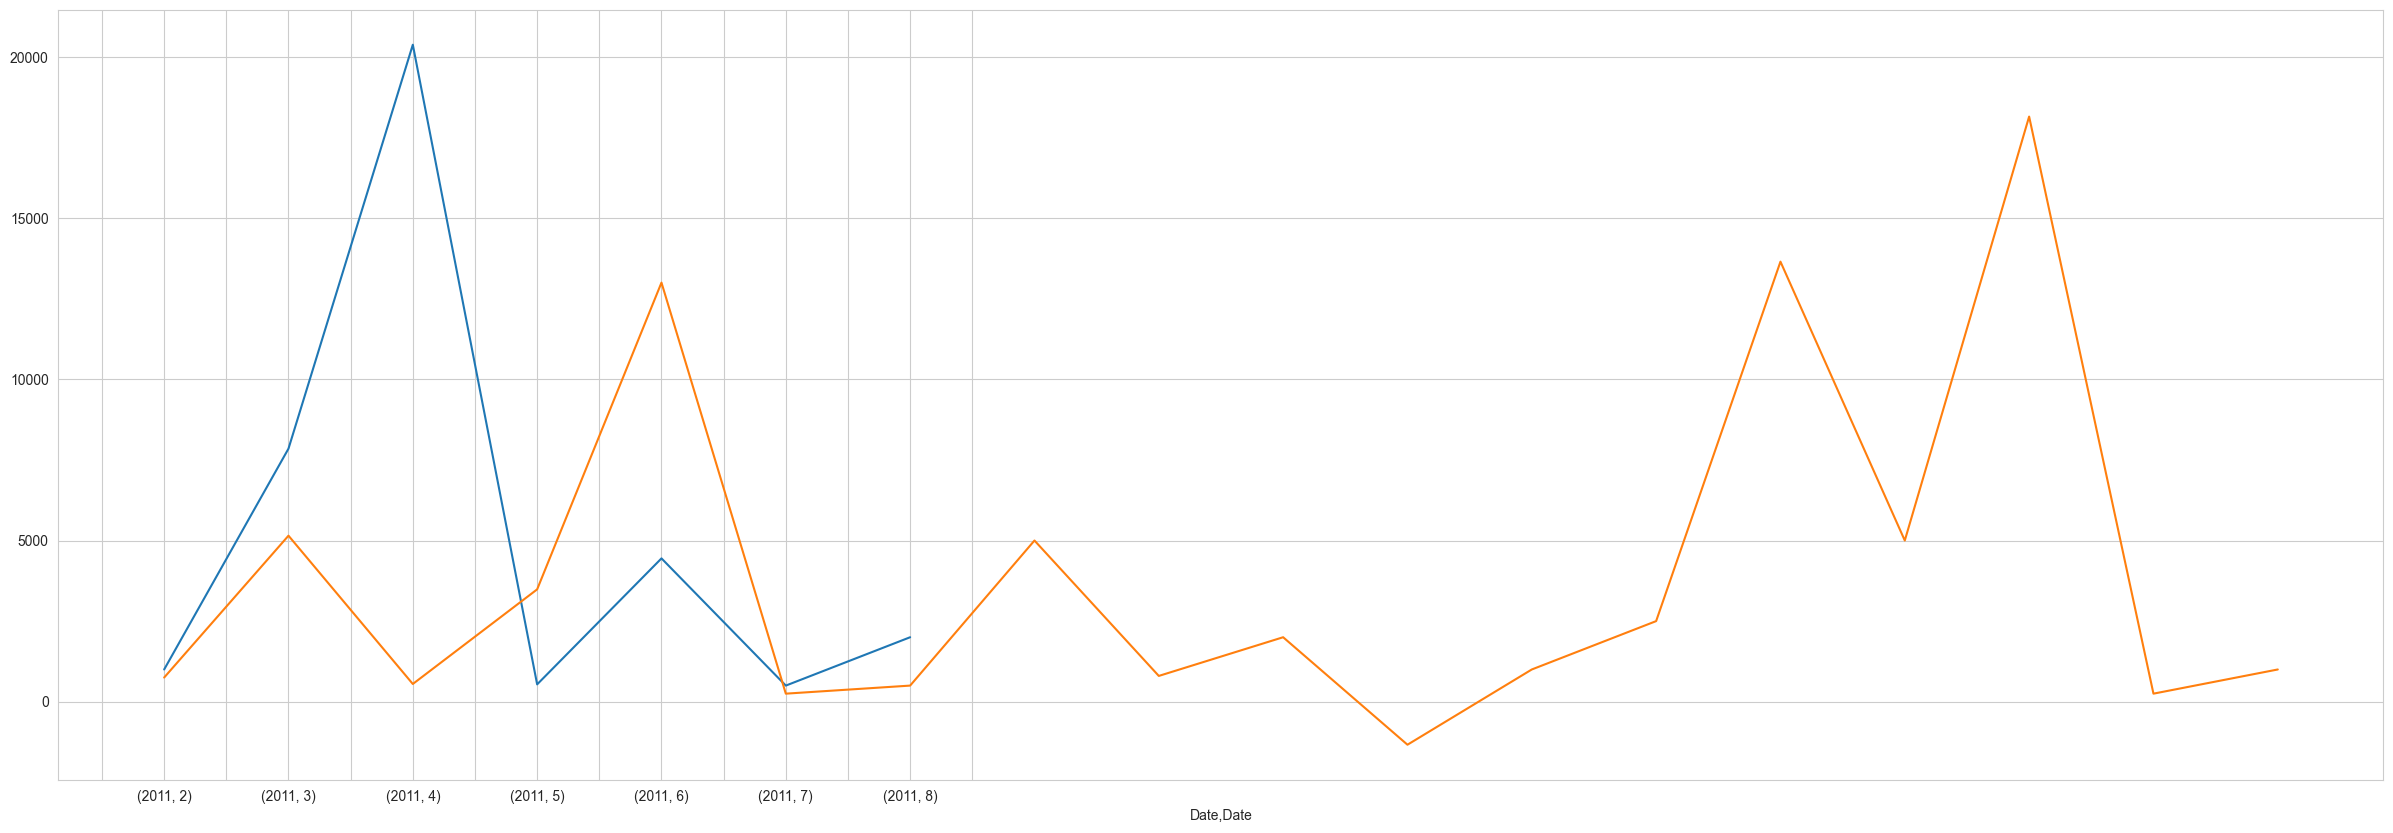

In [247]:
#disregard, was checking refunds over time for one candidate
#second cand is blue (winning)
examples = [['N00013856', 'N00030836']]

figure(figsize=(30, 10))
for cid in examples[0]:
    bug = buffs[years[0]].loc[buffs[years[0]]['RecipID'] == cid]
    bug = pd.DataFrame(bug[['Date', 'Amount']])

    bug['Date'] = pd.to_datetime(bug['Date'], format="%m/%d/%Y")

    bug = bug.sort_values(by='Date')
    plt.locator_params(axis='x', nbins=24)
    bug = bug.groupby(by=[bug.Date.dt.year,bug.Date.dt.month ])['Amount'].sum().plot()
# plt.plot(bug['Amount'])
#plt.show()


In [248]:

#roll up contributions for that year
results = pd.DataFrame()
for yr in years:
    #open each file and just get columns we need
    df = buffs[yr]
    df = df[["CycleIndivs","RecipID", "Amount", "Gender" ]]
    df['Female'] = np.where(df['Gender']=='F', 1, 0)
    df['Male'] = np.where(df['Gender']=='M', 1, 0)

    df = df.groupby(by=['CycleIndivs',"RecipID"], as_index=False).sum()
    results = results.append(df)

results.shape

/Users/admin/Documents/GitHub/csci6364/estimator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/admin/Documents/GitHub/csci6364/estimator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(7051, 5)

In [249]:
results.head()



,CycleIndivs,RecipID,Amount,Female,Male
0,2012,,300283,140,252
1,2012,C00000042,1000,0,1
2,2012,C00000059,1000,0,1
3,2012,C00000422,784390,253,741
4,2012,C00000638,19190,12,28


In [250]:
#keep only senate candidates that are running this cycle year
for yr in years:
    df = buffs_cand[yr]
    df = df.loc[(df['CycleCand']=="Y") & (df['DistIDRunFor'].str.contains(r'..S.')) & (df['CurrCand']=="Y") ]
    df = df.drop_duplicates(subset='CID', keep="first")

    buffs_cand[yr] = df


In [251]:
buffs_cand[years[0]].shape

#buffs_cand[yr].head()

(167, 12)

In [252]:
buffs_cand[years[0]].head()

,CycleCands,FECCandID,CID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCodeCands,NoPacs
5061,2012,S0CA00199,N00007364,Dianne Feinstein (D),D,CAS2,CAS2,Y,Y,I,DW,
5083,2012,S0CT00151,N00031165,Linda McMahon (R),R,CTS1,,Y,Y,O,RL,
5093,2012,S0CT00250,N00033229,Jeff Russell (3),3,CTS1,,Y,Y,O,3L,
5120,2012,S0FL00577,N00032622,Robert Monroe (I),I,FLS1,,Y,Y,C,3L,
5125,2012,S0HI00118,N00013164,Art Reyes (D),D,HIS2,,Y,Y,O,DL,


In [253]:
#append contribution amounts to candidate info

results = buffs_cand[years[0]].merge(results,left_on='CID', right_on='RecipID', how='left')

results['incumbent'] = np.where(results['CRPICO'] == 'I', 1, 0)

In [254]:
results.shape

(167, 18)

In [255]:
results = results.fillna(0)
results.head()


,CycleCands,FECCandID,CID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCodeCands,NoPacs,CycleIndivs,RecipID,Amount,Female,Male,incumbent
0,2012,S0CA00199,N00007364,Dianne Feinstein (D),D,CAS2,CAS2,Y,Y,I,DW,,2012.0,N00007364,4394349.0,1469.0,2289.0,1
1,2012,S0CT00151,N00031165,Linda McMahon (R),R,CTS1,,Y,Y,O,RL,,2012.0,N00031165,40295112.0,354.0,735.0,0
2,2012,S0CT00250,N00033229,Jeff Russell (3),3,CTS1,,Y,Y,O,3L,,0.0,0,0.0,0.0,0.0,0
3,2012,S0FL00577,N00032622,Robert Monroe (I),I,FLS1,,Y,Y,C,3L,,0.0,0,0.0,0.0,0.0,0
4,2012,S0HI00118,N00013164,Art Reyes (D),D,HIS2,,Y,Y,O,DL,,0.0,0,0.0,0.0,0.0,0


In [256]:
members_df = pd.read_csv(f"../data/members_cid.csv")

In [257]:
#add if they won

won = []

for i, result in results.iterrows():

    cid = result['RecipID']
    year = result['CycleIndivs']

    exp = members_df.loc[ (members_df['CID']==cid ) & (members_df['Year']==year+1)]
    if exp.empty :
        won.append(0)
    else:
        won.append(1)

results['label']=won

In [258]:
results.head(100)

,CycleCands,FECCandID,CID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCodeCands,NoPacs,CycleIndivs,RecipID,Amount,Female,Male,incumbent,label
0,2012,S0CA00199,N00007364,Dianne Feinstein (D),D,CAS2,CAS2,Y,Y,I,DW,,2012.0,N00007364,4394349.0,1469.0,2289.0,1,1
1,2012,S0CT00151,N00031165,Linda McMahon (R),R,CTS1,,Y,Y,O,RL,,2012.0,N00031165,40295112.0,354.0,735.0,0,0
2,2012,S0CT00250,N00033229,Jeff Russell (3),3,CTS1,,Y,Y,O,3L,,0.0,0,0.0,0.0,0.0,0,0
3,2012,S0FL00577,N00032622,Robert Monroe (I),I,FLS1,,Y,Y,C,3L,,0.0,0,0.0,0.0,0.0,0,0
4,2012,S0HI00118,N00013164,Art Reyes (D),D,HIS2,,Y,Y,O,DL,,0.0,0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2012,S2TN00322,N00034831,James Higdon (I),I,TNS1,,Y,Y,C,3L,,0.0,0,0.0,0.0,0.0,0,0
96,2012,S2TN00330,N00034832,Michel Joseph Long (I),I,TNS1,,Y,Y,C,3L,,0.0,0,0.0,0.0,0.0,0,0
97,2012,S2TN00348,N00035150,Troy Scoggin (I),I,TNS1,,Y,Y,C,3L,,0.0,0,0.0,0.0,0.0,0,0
98,2012,S2TN00355,N00034992,Martin Pleasant (3),3,TNS1,,Y,Y,C,3L,,0.0,0,0.0,0.0,0.0,0,0


In [259]:

#create the amount raised by percent ahead or behidn opponents and call is amountranksimple (but it's more complex..)
open_seats = results['DistIDRunFor'].unique()

open_seats

ranks = pd.DataFrame()
simple_ranks = pd.DataFrame()

for seat in open_seats:

    #get all candidates for this seat
    seat_candidates = pd.DataFrame(results.loc[results['DistIDRunFor'] == seat])

    #get the top amount for that seat
    max_amount = seat_candidates['Amount'].max()

    n = len(seat_candidates)
    i=0

    seat_candidates = seat_candidates.sort_values(by='Amount', ascending=False, ignore_index=True)

    for i in seat_candidates.index:

        amount = seat_candidates['Amount'][i]
        cid = seat_candidates['CID'][i]
        rank = pd.DataFrame( [[cid, (amount/max_amount)]], columns=['CID', 'AmountRank'])
        ranks = ranks.append(rank)


        simple_rank = None
        if i==0:
            #top amount
            if n > 1:
                competitor_amount = seat_candidates['Amount'][1]
                if competitor_amount ==0:
                    if amount>0:
                        simple_rank = pd.DataFrame([[cid, 1]], columns=['CID', 'AmountRankSimple'])
                    else:
                        simple_rank = pd.DataFrame([[cid, 2]], columns=['CID', 'AmountRankSimple'])
                    simple_ranks.append(simple_rank)
                    continue

                percent_diff = abs( competitor_amount - amount ) /competitor_amount
                if  percent_diff > .05:
                    simple_rank = pd.DataFrame([[cid, 1]], columns=['CID', 'AmountRankSimple'])

                else:
                    simple_rank = pd.DataFrame([[cid, 2]], columns=['CID', 'AmountRankSimple'])

            else:
                #no competitors
                simple_rank = pd.DataFrame([[cid, 1]], columns=['CID', 'AmountRankSimple'])

        else:
                #not top amount
                top_amount = seat_candidates['Amount'][0]
                percent_diff = abs( top_amount - amount ) /amount
                if amount ==0:
                    if top_amount>0:
                        simple_rank = pd.DataFrame([[cid, 3]], columns=['CID', 'AmountRankSimple'])
                    else:
                        simple_rank = pd.DataFrame([[cid, 2]], columns=['CID', 'AmountRankSimple'])
                    simple_ranks.append(simple_rank)
                    continue

                if percent_diff <=.05:
                    simple_rank = pd.DataFrame([[cid, 2]], columns=['CID', 'AmountRankSimple'])
                else:
                    simple_rank = pd.DataFrame([[cid, 3]], columns=['CID', 'AmountRankSimple'])

        if simple_rank.empty:
            raise Exception('Not good')

        simple_ranks = simple_ranks.append(simple_rank)
        i+=1



results = results.merge(ranks, on='CID')
results = results.merge(simple_ranks, on='CID')


/Users/admin/Documents/GitHub/csci6364/estimator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


In [260]:
results.head(400)

,CycleCands,FECCandID,CID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,...,NoPacs,CycleIndivs,RecipID,Amount,Female,Male,incumbent,label,AmountRank,AmountRankSimple
0,2012,S0CA00199,N00007364,Dianne Feinstein (D),D,CAS2,CAS2,Y,Y,I,...,,2012.0,N00007364,4394349.0,1469.0,2289.0,1,1,1.000000,1
1,2012,S0CT00151,N00031165,Linda McMahon (R),R,CTS1,,Y,Y,O,...,,2012.0,N00031165,40295112.0,354.0,735.0,0,0,1.000000,1
2,2012,S0IN00186,N00032819,Jack Rooney (I),I,INS1,,Y,Y,O,...,,2012.0,N00032819,6000.0,0.0,1.0,0,0,0.001020,3
3,2012,S0MA00109,N00031174,Scott Brown (R),R,MAS1,MAS1,Y,Y,I,...,,2012.0,N00031174,19013674.0,5778.0,19458.0,1,0,0.845582,3
4,2012,S0NY00410,N00027658,Kirsten Gillibrand (D),D,NYS1,NYS1,Y,Y,I,...,,2012.0,N00027658,11391700.0,4052.0,5693.0,1,1,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2012,S8MS00196,N00003280,Roger Wicker (R),R,MSS2,MSS2,Y,Y,I,...,,2012.0,N00003280,1561283.0,206.0,1345.0,1,1,1.000000,1
83,2012,S8NE00067,N00005303,Bob Kerrey (D),D,NES1,,Y,Y,O,...,,2012.0,N00005303,4069602.0,1387.0,2978.0,0,0,1.000000,1
84,2012,S8NM00168,N00006546,Heather A Wilson (R),R,NMS1,,Y,Y,O,...,,2012.0,N00006546,4771070.0,1677.0,4299.0,0,0,1.000000,1
85,2012,S8VA00214,N00009957,George Allen (R),R,VAS1,,Y,Y,O,...,,2012.0,N00009957,9867114.0,2481.0,7677.0,0,0,0.729512,3


In [261]:
results.to_csv(f"../data/candidate_summary_senators_20{years[0]}.csv")

In [262]:
results.loc[results['AmountRankSimple']==1]

,CycleCands,FECCandID,CID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,...,NoPacs,CycleIndivs,RecipID,Amount,Female,Male,incumbent,label,AmountRank,AmountRankSimple
0,2012,S0CA00199,N00007364,Dianne Feinstein (D),D,CAS2,CAS2,Y,Y,I,...,,2012.0,N00007364,4394349.0,1469.0,2289.0,1,1,1.0,1
1,2012,S0CT00151,N00031165,Linda McMahon (R),R,CTS1,,Y,Y,O,...,,2012.0,N00031165,40295112.0,354.0,735.0,0,0,1.0,1
4,2012,S0NY00410,N00027658,Kirsten Gillibrand (D),D,NYS1,NYS1,Y,Y,I,...,,2012.0,N00027658,11391700.0,4052.0,5693.0,1,1,1.0,1
6,2012,S0WV00090,N00032838,Joe Manchin (D),D,WVS1,WVS1,Y,Y,I,...,,2012.0,N00032838,2799179.0,501.0,1836.0,1,1,1.0,1
7,2012,S2AZ00141,N00009573,Jeff Flake (R),R,AZS2,AZ06,Y,Y,O,...,,2012.0,N00009573,7265721.0,1480.0,6017.0,0,1,1.0,1
19,2012,S2HI00114,N00033707,Linda Lingle (R),R,HIS2,,Y,Y,O,...,,2012.0,N00033707,4309797.0,1091.0,2758.0,0,0,1.0,1
20,2012,S2IN00083,N00003900,Richard E Mourdock (R),R,INS1,,Y,Y,O,...,,2012.0,N00003900,5880625.0,1496.0,5410.0,0,0,1.0,1
23,2012,S2MA00170,N00033492,Elizabeth Warren (D),D,MAS1,,Y,Y,C,...,,2012.0,N00033492,22485898.0,16241.0,19017.0,0,1,1.0,1
28,2012,S2ME00109,N00034580,Angus King (I),I,MES1,,Y,Y,O,...,,2012.0,N00034580,2182785.0,768.0,1747.0,0,1,1.0,1
35,2012,S2ND00073,N00031629,Rick Berg (R),R,NDS2,ND01,Y,Y,O,...,,2012.0,N00031629,4299999.0,880.0,3046.0,0,0,1.0,1
